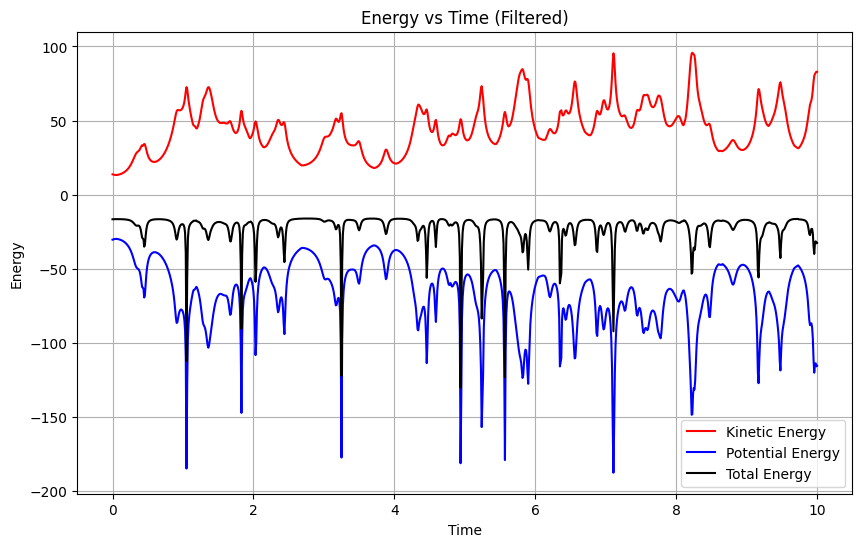

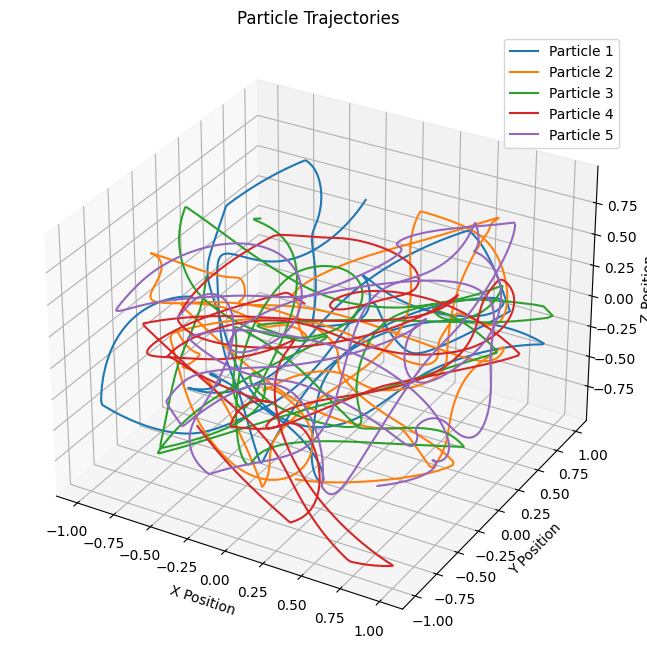

In [5]:
import matplotlib
%matplotlib inline
import utils as ut
import importlib
from torch_scatter import scatter
import e3nn
from e3nn.math import soft_one_hot_linspace
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.nn as torch_nn

importlib.reload(ut)

seed_value = 42

N = 5  # Number of particles
tEnd = 10.0  # time at which simulation ends
dt = 0.01  # timestep
softening = 0.15  # softening length
G = 1.0  # Newton's Gravitational Constant
boxSize = 1.0
mass_coef = 10.0
dims = 3
LOG_WANDB = False

hparams = {
    'N': N,  # Number of particles
    'tEnd': tEnd,  # Time at which simulation ends
    'dt': dt,  # Timestep
    'G': G,  # Newton's Gravitational Constant
    'boxSize': boxSize,  # Size of the simulation box
    'mass_coef': mass_coef  # Mass coefficient
}

combined_data = ut.simulate_gravitational_system(seed_value, N, tEnd, dt, softening, G, boxSize, mass_coef, dims=dims,
                                                 init_boxsize=boxSize)


combined_data shape: (999, 5, 6)
inputs_np shape: (998, 5, 6)
targets_np shape: (998, 5, 6)


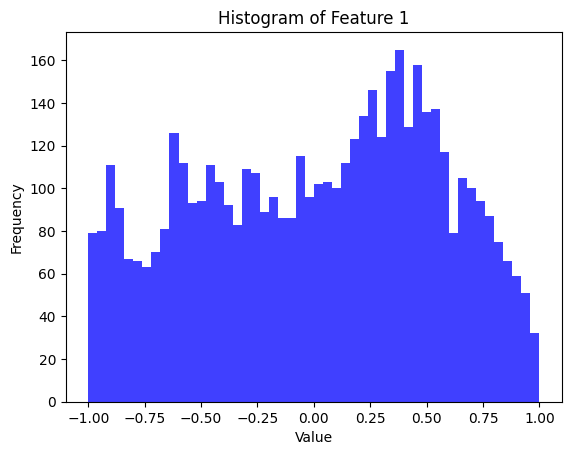

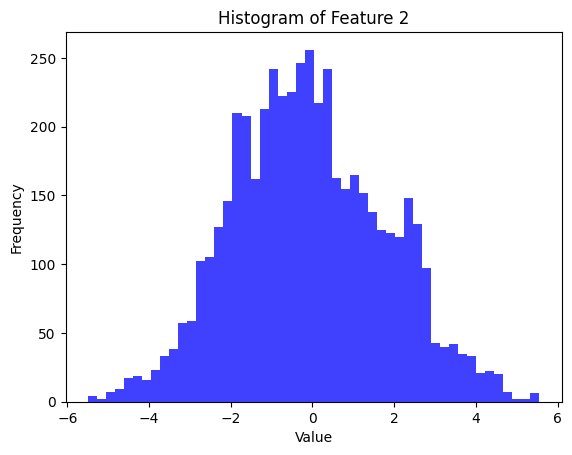

Normalized:


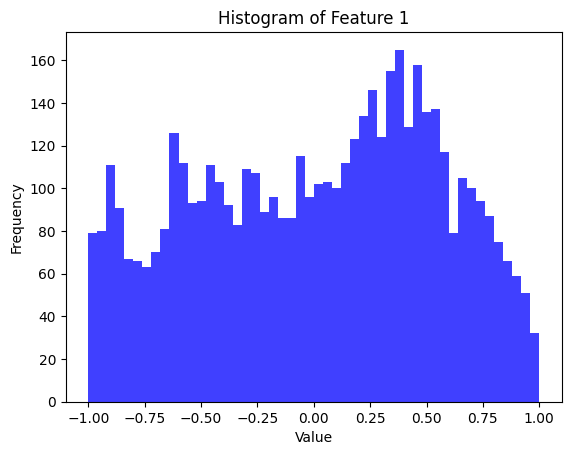

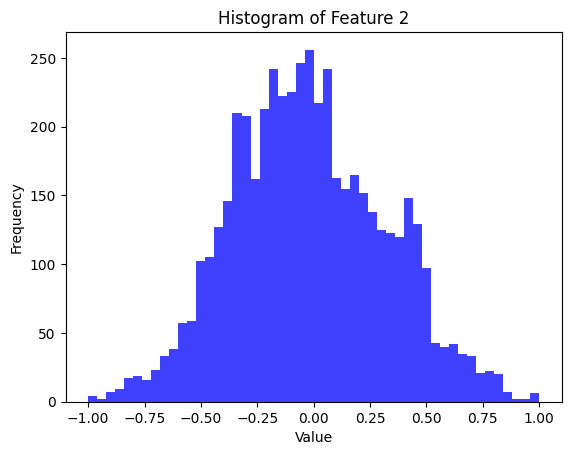

In [6]:
inputs_np, targets_np = ut.process_data(combined_data, dims=dims)

# Dataloader

In [7]:
def create_fully_connected_data_with_edge_features(node_features, positions, targets, max_radius, num_basis):
    num_nodes = node_features.size(0)
    device = node_features.device

    # Generate fully connected edge_index for num_nodes
    row = torch.arange(num_nodes, device=device).repeat_interleave(num_nodes)
    col = torch.arange(num_nodes, device=device).repeat(num_nodes)
    edge_index = torch.stack([row, col], dim=0)

    # Avoid self-loops
    edge_index = edge_index[:, row != col]

    # Calculate edge features
    edge_vec = positions[edge_index[0]] - positions[edge_index[1]]
    edge_features = soft_one_hot_linspace(
        edge_vec.norm(dim=1),
        0.0,
        max_radius,
        num_basis,
        basis='smooth_finite',
        cutoff=True
    ).mul(num_basis ** 0.5)

    y = targets.detach().to(device).to(torch.float32)

    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=y, edge_vec=edge_vec)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
d = (boxSize**2 + boxSize**2 + boxSize**2)**0.5
max_radius = d
num_basis = 10

inputs_tensor = torch.tensor(inputs_np, dtype=torch.float32)
targets_tensor = torch.tensor(targets_np, dtype=torch.float32)

data_list = []

for index, simulation_step_graph in enumerate(inputs_tensor):
    node_features = simulation_step_graph
    positions = node_features[..., :dims]
    targets = targets_tensor[index, ...]

    data = create_fully_connected_data_with_edge_features(node_features, positions, targets,
                                                          max_radius=max_radius, num_basis=num_basis)
    data_list.append(data)

data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

# Model


In [16]:
class Convolution(torch.nn.Module):
    def __init__(self, irreps_in, irreps_sh, irreps_out, num_neighbors, hidden_layer=256, embedding_dim=10) -> None:
        super().__init__()

        self.num_neighbors = num_neighbors

        tp = e3nn.o3.FullyConnectedTensorProduct(
            irreps_in1=irreps_in,
            irreps_in2=irreps_sh,
            irreps_out=irreps_out,
            internal_weights=False,
            shared_weights=False,
        )
        self.fc = e3nn.nn.FullyConnectedNet([embedding_dim, hidden_layer, tp.weight_numel], torch.relu)
        self.tp = tp
        self.irreps_out = self.tp.irreps_out

    def forward(self, node_features, edge_src, edge_dst, edge_attr, edge_scalars) -> torch.Tensor:
        weight = self.fc(edge_scalars)
        edge_features = self.tp(node_features[edge_src], edge_attr, weight)
        node_features = scatter(edge_features, edge_dst, dim=0).div(self.num_neighbors ** 0.5)
        return node_features


class NbodyConv(torch.nn.Module):
    def __init__(self, l=2, hidden_layers=256, max_radius=None, num_basis=10) -> None:
        super().__init__()
        self.irreps_sh: e3nn.o3.Irreps = e3nn.o3.Irreps.spherical_harmonics(l)
        self.irreps_input = e3nn.o3.Irreps("2x1o")
        self.irreps_output = e3nn.o3.Irreps("2x1o")
        self.max_radius = max_radius
        self.num_basis = num_basis
        self.hidden_layers = hidden_layers

        self.tensor_product = e3nn.o3.FullyConnectedTensorProduct(
            self.irreps_input,
            self.irreps_sh,
            self.irreps_output,
            shared_weights=False)
        
        self.conv = Convolution(self.irreps_input, self.irreps_sh, self.irreps_output, N-1, hidden_layer=self.hidden_layers, embedding_dim=num_basis)
        self.gate = e3nn.nn.Gate(
            "16x0e + 16x0o",
            [torch.relu, torch.abs],  # scalar
            "8x0e + 8x0o + 8x0e + 8x0o",
            [torch.relu, torch.tanh, torch.relu, torch.tanh],  # gates (scalars)
            "16x1o + 16x1e",  # gated tensors, num_irreps has to match with gates
        )

    def forward(self, data) -> torch.Tensor:
        num_nodes = N
        num_neighbors = num_nodes - 1
        edge_src, edge_dst = data.edge_index

        spherical_harmonics = e3nn.o3.spherical_harmonics(self.irreps_sh, data.edge_vec, normalize=True,
                                                     normalization='component')

        x = self.conv(data.x, edge_src, edge_dst, spherical_harmonics, data.edge_attr)
        
        #x = self.gate(x)        
        #x = self.conv(data.x, edge_src, edge_dst, spherical_harmonics, data.edge_attr)
        #return scatter(x, data.batch, dim=0).div(num_nodes**0.5)
        return x


model = NbodyConv()
print("wtf")
for batch in data_loader:
    # batch.x: current state node features
    # batch.edge_index: edges for fully connected graph
    # batch.edge_attr: edge features
    # batch.y: labels for the next state of the simulation
    outputs = model(batch)


wtf


# Training

In [17]:
model = NbodyConv()
for batch in data_loader:
    # batch.x: current state node features
    # batch.edge_index: edges for fully connected graph
    # batch.edge_attr: edge features
    # batch.y: labels for the next state of the simulation
    outputs = model(batch)
    print(batch)
    print(outputs.shape)


DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_index=[2, 640], edge_attr=[640, 10], y=[160, 6], edge_vec=[640, 3], batch=[160], ptr=[33])
torch.Size([160, 6])
DataBatch(x=[160, 6], edge_

In [20]:
model = NbodyConv()
num_epochs = 1000
lr = 1e-3
criterion = torch_nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.train()
for epoch in range(num_epochs):
    total_metrics = {
        "loss": 0, "loss_pos": 0, "loss_vel": 0,
        "perc_error_pos": 0, "perc_error_vel": 0, "perc_error_pos_vs_vel_l1": 0, "perc_error_pos_vs_vel_l2": 0
    }
    num_batches = 0
    for batch in data_loader:
        targets = batch.y  # Adjust based on your data loading method

        # Forward pass
        outputs = model(batch)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            predicted_pos = outputs[..., :dims]
            target_pos = targets[..., :dims]

            predicted_vel = outputs[..., dims:]
            target_vel = targets[..., dims:]

            loss_pos = criterion(predicted_pos, target_pos)
            loss_vel = criterion(predicted_vel, target_vel)

            # Calculate percentage errors
            perc_error_pos = (torch.norm(predicted_pos - target_pos, dim=1) /
                              torch.norm(target_pos, dim=1)).mean() * 100

            perc_error_vel = (torch.norm(predicted_vel - target_vel, dim=1) /
                              torch.norm(target_vel, dim=1)).mean() * 100

            perc_error_pos_vs_vel_l1 = (torch.abs(predicted_pos - target_pos).mean() /
                                        torch.norm(target_vel, dim=1)).mean() * 100

            perc_error_pos_vs_vel_l2 = (torch.norm(predicted_pos - target_pos, dim=1) /
                                        torch.norm(target_vel, dim=1)).mean() * 100

            total_metrics["loss"] += loss.item()
            total_metrics["loss_pos"] += loss_pos.item()
            total_metrics["loss_vel"] += loss_vel.item()
            total_metrics["perc_error_pos"] += perc_error_pos.item()
            total_metrics["perc_error_vel"] += perc_error_vel.item()
            total_metrics["perc_error_pos_vs_vel_l1"] += perc_error_pos_vs_vel_l1.item()
            total_metrics["perc_error_pos_vs_vel_l2"] += perc_error_pos_vs_vel_l2.item()

        num_batches += 1

    if epoch % 1 == 0:
        avg_metrics = {k: v / num_batches for k, v in total_metrics.items()}
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], avg_both: {avg_metrics['loss']:.5f}, avg_pos: {avg_metrics['loss_pos']: .5f}, avg_vel: {avg_metrics['loss_vel']: .5f}, perc_pos: {avg_metrics['perc_error_pos']: .5f}%, perc_vel: {avg_metrics['perc_error_vel']: .5f}%")

Epoch [1/1000], avg_both: 0.37421, avg_pos:  0.44780, avg_vel:  0.30061, perc_pos:  114.23847%, perc_vel:  136.48589%
Epoch [2/1000], avg_both: 0.30480, avg_pos:  0.32992, avg_vel:  0.27968, perc_pos:  84.36493%, perc_vel:  123.93399%
Epoch [3/1000], avg_both: 0.26553, avg_pos:  0.26469, avg_vel:  0.26638, perc_pos:  66.06050%, perc_vel:  116.11460%
Epoch [4/1000], avg_both: 0.23972, avg_pos:  0.22152, avg_vel:  0.25793, perc_pos:  53.53790%, perc_vel:  111.29266%
Epoch [5/1000], avg_both: 0.22369, avg_pos:  0.19375, avg_vel:  0.25362, perc_pos:  46.43137%, perc_vel:  107.44645%
Epoch [6/1000], avg_both: 0.21452, avg_pos:  0.17861, avg_vel:  0.25043, perc_pos:  42.34455%, perc_vel:  105.57805%
Epoch [7/1000], avg_both: 0.20940, avg_pos:  0.17140, avg_vel:  0.24741, perc_pos:  40.91434%, perc_vel:  103.82729%
Epoch [8/1000], avg_both: 0.20608, avg_pos:  0.16619, avg_vel:  0.24597, perc_pos:  39.39900%, perc_vel:  103.25128%
Epoch [9/1000], avg_both: 0.20427, avg_pos:  0.16378, avg_vel: 

KeyboardInterrupt: 